In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install datasets

!pip install datasets transformers torch evaluate scikit-learn

from datasets import load_dataset
import evaluate
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset

ds = load_dataset("csv", data_files="/content/drive/MyDrive/ML Final Project/ML final model/train.csv")["train"]


ds
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

#ds = load_dataset("csv", data_files="/content/drive/MyDrive/ML Final Project/ML final model/train_gus2.csv")["train"]
#ds = load_dataset("csv", data_files="/content/drive/MyDrive/z.csv")["train"]



ds
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
print(ds)

Dataset({
    features: ['Category', 'Text'],
    num_rows: 13389
})


In [5]:
# Define preprocessing function
def tokenize_function(examples):
    #tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    #return tokenizer(examples["Text"], truncation=True, padding="max_length", max_length=512)
    return tokenizer(
        examples["Text"],  # Replace "Text" with the correct column name if different
        truncation=True,
        padding="max_length",
        max_length=512,
    )

# Tokenize dataset
tokenized_datasets = ds.map(tokenize_function, batched=True)


Map:   0%|          | 0/13389 [00:00<?, ? examples/s]

In [6]:
print(tokenized_datasets)


Dataset({
    features: ['Category', 'Text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13389
})


In [7]:
# def preprocess_labels(examples):
#     examples["labels"] = [int(label) for label in examples["Category"]]  # Replace "Label" with the correct column name
#     return examples

# tokenized_datasets = tokenized_datasets.map(preprocess_labels)

from datasets import ClassLabel

# Define label preprocessing
def preprocess_labels(dataset):
    # Ensure the label column is retained
    if "Category" not in dataset.column_names:
        raise KeyError("Category column not found. Verify your dataset.")

    # Create a ClassLabel object to encode categories
    label_encoder = ClassLabel(
        num_classes=len(set(dataset["Category"])),
        names=sorted(set(dataset["Category"]))
    )

    # Map string labels to integers
    dataset = dataset.map(lambda example: {"labels": label_encoder.str2int(example["Category"])})
    return dataset, label_encoder

# Preprocess labels
tokenized_datasets, label_encoder = preprocess_labels(tokenized_datasets)

# Verify label mapping
print("Label mapping:", label_encoder)
print("First 5 labels in train set:", tokenized_datasets["labels"][:5])



Map:   0%|          | 0/13389 [00:00<?, ? examples/s]

Label mapping: ClassLabel(names=['Accountant', 'Advocate', 'Agriculture', 'Apparel', 'Architecture', 'Arts', 'Automobile', 'Aviation', 'BPO', 'Banking', 'Blockchain', 'Building and Construction', 'Business Analyst', 'Civil Engineer', 'Consultant', 'Data Science', 'Database', 'Designing', 'DevOps', 'Digital Media', 'DotNet Developer', 'ETL Developer', 'Education', 'Electrical Engineering', 'Finance', 'Food and Beverages', 'Health and Fitness', 'Human Resources', 'Information Technology', 'Java Developer', 'Management', 'Mechanical Engineer', 'Network Security Engineer', 'Operations Manager', 'PMO', 'Public Relations', 'Python Developer', 'React Developer', 'SAP Developer', 'SQL Developer', 'Sales', 'Testing', 'Web Designing'], id=None)
First 5 labels in train set: [0, 0, 0, 0, 0]


In [8]:
# Split into train/test sets (if not already split)
train_data = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_data["train"]
test_dataset = train_data["test"]

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

# First 5 items
print("First 5 items in the test dataset:")
print(test_dataset[:5])

# Last 5 items
print("\nLast 5 items in the test dataset:")
print(test_dataset[-5:])


Train size: 10711
Test size: 2678
First 5 items in the test dataset:
{'Category': ['SQL Developer', 'Arts', 'Food and Beverages', 'Architecture', 'Advocate'], 'Text': ['robert smith oracle plsql developer phone 0123456789 email infoqwikresumecom website qwikresumecom summary oracle plsql developer 7 years experience various phases sdlc project requirement study highlevel design lowlevel design coding testing quality assurance documentation implementation project planning expertise data modeling large data warehouses supporting business intelligence applications olap also online transaction processing systems oltp core competencies oracle ms sql server ibm db2 udb 8070 environment windows xp red hat linux unix sun solaris programming languages plsql sql tsql professional experience oracle plsql developer hp infosystem llc march 2010september 2013 key deliverables responsible gathering requirements users reports development interface program customizations analyzing business process crea

In [11]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from evaluate import load
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define a data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=43
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"  # Disable WandB
)

accuracy_metric = load("accuracy")
# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get predicted class indices

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")

    # Return a dictionary with the metrics
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,  # Added this line to specify the data collator
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.599500,0.876173,0.863704,0.861928,0.863704,0.857695


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.599500,0.876173,0.863704,0.861928,0.863704,0.857695
2,0.929800,0.491080,0.899552,0.901596,0.899552,0.898742
3,0.395600,0.466185,0.901419,0.903272,0.901419,0.900771
4,0.284100,0.416466,0.915235,0.916879,0.915235,0.915276
5,0.244800,0.425066,0.914115,0.915267,0.914115,0.913692


TrainOutput(global_step=3350, training_loss=0.7679823371545592, metrics={'train_runtime': 1187.0394, 'train_samples_per_second': 45.116, 'train_steps_per_second': 2.822, 'total_flos': 1.409609975115264e+16, 'train_loss': 0.7679823371545592, 'epoch': 5.0})

In [ ]:
# Save model
model.save_pretrained("./results")
tokenizer.save_pretrained("./results")


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets transformers torch evaluate scikit-learn

import pandas as pd
import numpy as np
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from sklearn import preprocessing

label_column = "Category"
num_labels=43
output_attentions=False
output_hidden_states=False
do_lower_case=True
add_special_tokens=True
max_length=512
pad_to_max_length=True
return_attention_mask=True
truncation=True

ds = load_dataset("csv", data_files="/content/drive/MyDrive/ML Final Project/ML final model/train_gus2.csv")["train"]

le = preprocessing.LabelEncoder()
le.fit(ds[label_column])

# model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/ML Final Project/ML final model")
# tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/ML Final Project/ML final model")
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/ML Final Project/ML final model FINAL")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/ML Final Project/ML final model FINAL")

model = model.to('cuda').eval()

In [ ]:
#Stan test
sent = """
Stanislav (Stan) Danaev 800 W College Ave, St.Peter, MN, 56082 | (507) 594-1695 | standanaev@gustavus.edu EDUCATION Bachelor of Arts - Public Accounting and Computer Science, 3.9 Cumulative GPA May 2025 Gustavus Adolphus College, St. Peter, MN PROFESSIONAL EXPERIENCE Board of Trustees Investment Committee Member September 2023- Present Conducted a research study on the impacts of AI in 11 economic sectors, focusing on revenue generation and cost savings Gained an understanding of the inner workings of machine learning and the importance of data Presented and recommended to the Board of Trustees investment opportunities in sectors with the highest return on investment Financial Services Audit Intern June 2023 - August 2023 Ernst Young LLP, Minneapolis, MN Analyzed business operations and significant financial accounts for 2 wealth management clients to successfully assist senior team in independent audit Acquired specialized knowledge about U.S and European financial markets and instruments (derivatives, stocks, bonds) Learned to analyze and understand inputs in building discounted cash flow models for level 3 investments
Internal Audit and FP&A Intern May 2022 - August 2022 APi Group, New Brighton, MN ● Assisted internal audit in maintaining and integrating SOX controls for 18 operational units ● Assisted financial planning and analysis team to forecast and budget $100 million corporate spending ● Supported accounting team in preparation of the financial reports ● Gained technical skills in analytical tools; Power BI, Visio, Excel ● Performed financial analysis on income statements and balance sheets for seven international subsidiaries
ACADEMIC INVOLVEMENT Athletics September 2020 - Present Gustavus Men’s Varsity Hockey ● Balance high caliber practice, training, competition and travel schedule while simultaneously prioritizing academic performance ● Mentor young student athletes entering the program on sport and academic balance, acclimation to college, and leadership ● Received Student-Athlete award for high athletic and academic achievement
Deloitte Case Competition November 2022 Deloitte, Minneapolis, MN ● Gained understanding of FASB codification system by conducting research for a case study ● Identified company’s financial statement representation issues by researching complicated accounting topic ASC 480 ● Suggested financial statement representation for a company to a Deloitte professional team
"""

encoded_dict = tokenizer.encode_plus(
    sent,
    add_special_tokens=add_special_tokens,
    max_length=max_length,
    padding='max_length',
    return_attention_mask=return_attention_mask,
    return_tensors='pt',
    truncation=truncation,
)
input_ids = encoded_dict['input_ids'].to('cuda')
attention_mask = encoded_dict['attention_mask'].to('cuda')

outputs = model(
    input_ids,
    token_type_ids=None,
    attention_mask=attention_mask
)
#print(f"Predicted Label ID: {label_id}, Classes in LabelEncoder: {le.classes_}")
label_id = np.argmax(outputs['logits'].cpu().detach().tolist(), axis=1)
print(f'Predicted: {le.inverse_transform(label_id)[0]}')

Predicted: Finance


In [ ]:
sent = """
Example resume
"""

encoded_dict = tokenizer.encode_plus(
    sent,
    add_special_tokens=add_special_tokens,
    max_length=max_length,
    padding='max_length',
    return_attention_mask=return_attention_mask,
    return_tensors='pt',
    truncation=truncation,
)
input_ids = encoded_dict['input_ids'].to('cuda')
attention_mask = encoded_dict['attention_mask'].to('cuda')

outputs = model(
    input_ids,
    token_type_ids=None,
    attention_mask=attention_mask
)
#print(f"Predicted Label ID: {label_id}, Classes in LabelEncoder: {le.classes_}")
label_id = np.argmax(outputs['logits'].cpu().detach().tolist(), axis=1)
print(f'Predicted: {le.inverse_transform(label_id)[0]}')

Predicted: Data Science


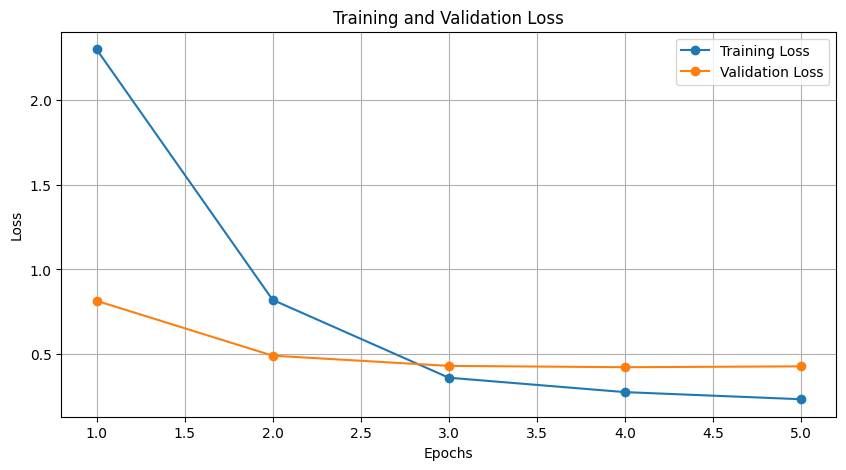

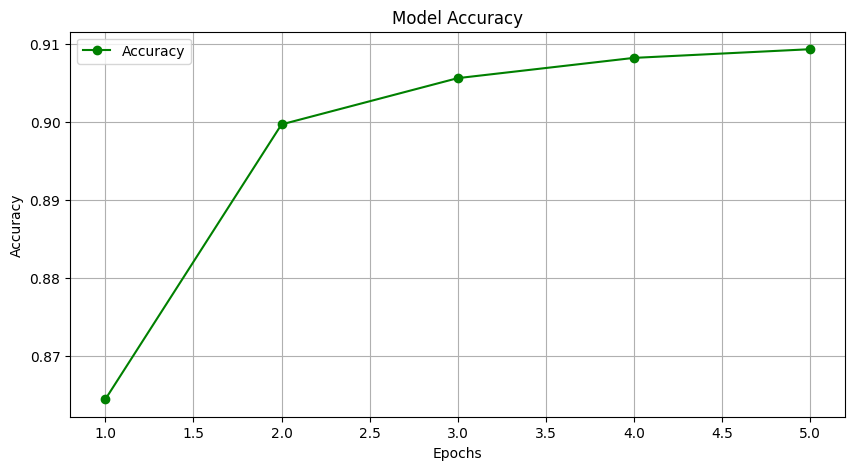

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = [1, 2, 3, 4, 5]
training_loss = [2.2998, 0.8205, 0.3611, 0.276, 0.2341]
validation_loss = [0.815083, 0.491222, 0.430886, 0.423021, 0.428082]
accuracy = [0.864413, 0.899703, 0.905646, 0.908247, 0.909361]

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()
